In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import StrMethodFormatter
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

import io
import numpy as np
import pandas as pd
import scipy.stats as stat
import statsmodels.api as sm

In [ ]:
from google.colab import files

FatTest = files.upload()
FatTrain = files.upload()

Saving test.csv to test.csv


Saving trains.csv to trains.csv


In [ ]:
FatTest_df = pd.read_csv(io.BytesIO(FatTest['test.csv']))
FatTest_df= FatTest_df.drop(['id'], axis=1) 
FatTrain_df = pd.read_csv(io.BytesIO(FatTrain['trains.csv']))
FatTrain_df= FatTrain_df.drop(['id'], axis=1) 

In [ ]:
print(FatTest_df.shape)
FatTrain_df.shape

(848, 15)


(3390, 16)

Train has considerably more values, any reason as to why that might be the case? Working through this a bit, I'm gathering the train and test are both necessary for a logistic regression? Let's try and give it a go.

## Obesity HeartHealth Summary

In a nutshell, this article goes over obesity and how it is associated with an increased risk of developing heart disease. And specifically, the type of heart disease is heart failure and coronary heart disease. The people writing the article believe that the way obesity occurs in the body is in itself increasing cardiovascular disease. Or in other words, changes in body composition are affecting hemodynamics which then alters the heart structure. One weird paradox that this problem creates in the article is that while obesity does increase someone’s fat mass it also increases someone’s amount of lean mass. Lean mass can contribute to better cardio health, which is a weird correlation considering we’re trying to focus on fat mass even though lean mass is also increasing. The main point of this article is to see how mechanisms can be established which will focus on how obesity can directly impact heart health and they’re doing this by focusing on body composition as well as adjusted measures of health, things like testing somebody’s oxygen consumption. They also get into work and improve someone’s situation and that goes into the basics like exercise and a better diet.

Given the variables we have to work with in the dataset, we will focus on trying to associate similar attributing factors to heart disease. The most intuitive, given the data, would be to establish higher risk factors for heart disease given a prior history of stroke, diabetes, or hypertension (high blood pressure). 

Since this test and train model is pushing us toward a logistic regression, we'll give it a go to try and spice things up. 

### Data Description
Demographic:

• Sex: male or female("M" or "F")

• Age: Age of the patient;(Continuous - Although the recorded ages have been truncated to whole numbers, the concept of age is continuous)

Behavioral

• is_smoking: whether or not the patient is a current smoker ("YES" or "NO")

• Cigs Per Day: the number of cigarettes that the person smoked on average in one day.(can be considered continuous as one can have any number of cigarettes, even half a cigarette.)

Medical( history)

• BP Meds: whether or not the patient was on blood pressure medication (Nominal)

• Prevalent Stroke: whether or not the patient had previously had a stroke (Nominal)

• Prevalent Hyp: whether or not the patient was hypertensive (Nominal)

• Diabetes: whether or not the patient had diabetes (Nominal)

Medical(current)

• Tot Chol: total cholesterol level (Continuous)

• Sys BP: systolic blood pressure (Continuous)

• Dia BP: diastolic blood pressure (Continuous)

• BMI: Body Mass Index (Continuous)

• Heart Rate: heart rate (Continuous - In medical research, variables such as heart rate though in fact discrete, yet are considered continuous because of large number of possible values.)

• Glucose: glucose level (Continuous)

Predict variable (desired target)

• 10 year risk of coronary heart disease CHD(binary: “1”, means “Yes”, “0” means “No”)

## Data Cleaning

Represent Yes/No and M/F as binary values

In [ ]:
#convert binary values to 0 and 1
def give_binary_values(dataset,col,one,zero): 
    dataset[col].loc[dataset[col]==one] = int(1)
    dataset[col].loc[dataset[col]==zero] = int(0)
    return dataset


Fill in missing data with the mean and/or median values to retain our shape. 

In [ ]:
#fill missing values
def handle_missing(dataset): 
    dataset = give_binary_values(dataset,'sex','F','M')
    dataset = give_binary_values(dataset,'is_smoking','YES','NO')

    dataset['education'] = dataset['education'].fillna(dataset['education'].median())
    dataset.loc[dataset['is_smoking']==0,'cigsPerDay']=0

    for i in range(2):
        correct_sex=(dataset['sex'] == i)
        for col in ['heartRate','BMI','totChol']:
            avg=dataset[col][correct_sex].mean()
            dataset.loc[correct_sex, col]=dataset.loc[correct_sex, col].fillna(avg)
        for col in ['BPMeds','cigsPerDay','glucose']:
            med=dataset[col][correct_sex].median()
            dataset.loc[correct_sex, col]=dataset.loc[correct_sex, col].fillna(med)
        dataset.loc[dataset["is_smoking"]==0,"cigsPerDay"]=0
        
    return dataset

In [ ]:
#fill missing values in the original files of train and test
FatTest_df = handle_missing(FatTest_df)
FatTrain_df = handle_missing(FatTrain_df)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [ ]:
print(FatTest_df.shape)
FatTrain_df.shape

(848, 15)


(3390, 16)

In [ ]:
FatTest_df.head()

,age,education,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose
0,43,2.0,0,1,35.0,0.0,0,0,0,207.0,117.0,65.0,24.42,60.0,100.0
1,56,3.0,1,0,0.0,0.0,0,0,0,192.0,122.0,82.5,28.61,68.0,58.0
2,58,1.0,1,1,20.0,0.0,0,1,0,260.0,180.0,100.0,25.56,100.0,77.0
3,47,3.0,1,0,0.0,0.0,0,0,0,231.0,102.5,66.0,23.40,70.0,78.0
4,44,1.0,0,0,0.0,0.0,0,0,0,160.0,118.5,87.0,25.81,54.0,79.0


In [ ]:
FatTrain_df.head()

,age,education,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,64,2.0,1,1,3.0,0.0,0,0,0,221.0,148.0,85.0,25.481353,90.0,80.0,1
1,36,4.0,0,0,0.0,0.0,0,1,0,212.0,168.0,98.0,29.770000,72.0,75.0,0
2,46,1.0,1,1,10.0,0.0,0,0,0,250.0,116.0,71.0,20.350000,88.0,94.0,0
3,50,1.0,0,1,20.0,0.0,0,1,0,233.0,158.0,88.0,28.260000,68.0,94.0,1
4,64,1.0,1,1,30.0,0.0,0,0,0,241.0,136.5,85.0,26.420000,70.0,77.0,0


Looking good, let's organize our training data into categorical and numerical variables so that we can differentiate between the two. 

In [ ]:
categTrain = FatTrain_df.loc[:, ("sex","prevalentStroke", "prevalentHyp", "is_smoking")]
categTest = FatTest_df.loc[:, ("sex","prevalentStroke", "prevalentHyp", "is_smoking")]

numerTrain = FatTrain_df.loc[:, ("age","education","cigsPerDay","BPMeds","diabetes", "totChol", "sysBP", "diaBP", "BMI","heartRate","glucose")]
numerTest = FatTest_df.loc[:, ("age","education","cigsPerDay","BPMeds","diabetes", "totChol", "sysBP", "diaBP", "BMI","heartRate","glucose")]

In [ ]:
numerTrain

,age,education,cigsPerDay,BPMeds,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose
0,64,2.0,3.0,0.0,0,221.0,148.0,85.0,25.481353,90.0,80.0
1,36,4.0,0.0,0.0,0,212.0,168.0,98.0,29.770000,72.0,75.0
2,46,1.0,10.0,0.0,0,250.0,116.0,71.0,20.350000,88.0,94.0
3,50,1.0,20.0,0.0,0,233.0,158.0,88.0,28.260000,68.0,94.0
4,64,1.0,30.0,0.0,0,241.0,136.5,85.0,26.420000,70.0,77.0
...,...,...,...,...,...,...,...,...,...,...,...
3385,60,1.0,0.0,0.0,0,261.0,123.5,79.0,29.280000,70.0,103.0
3386,46,1.0,0.0,0.0,0,199.0,102.0,56.0,21.960000,80.0,84.0
3387,44,3.0,3.0,0.0,0,352.0,164.0,119.0,28.920000,73.0,72.0
3388,60,1.0,0.0,0.0,0,191.0,167.0,105.0,23.010000,80.0,85.0


In [ ]:
categTrain

,sex,prevalentStroke,prevalentHyp,is_smoking
0,1,0,0,1
1,0,0,1,0
2,1,0,0,1
3,0,0,1,1
4,1,0,0,1
...,...,...,...,...
3385,1,0,0,0
3386,1,0,0,0
3387,0,0,1,1
3388,0,0,1,0


In [ ]:
def xy_correlation(dataset,title):
    f,ax = plt.subplots(figsize=(15,12))
    corr=dataset.corr()    
    sns.heatmap(corr, cmap = "GnBu", annot=True, annot_kws={'size':20}, ax=ax)
    ax.set_title(title, fontsize=20)
    plt.show()

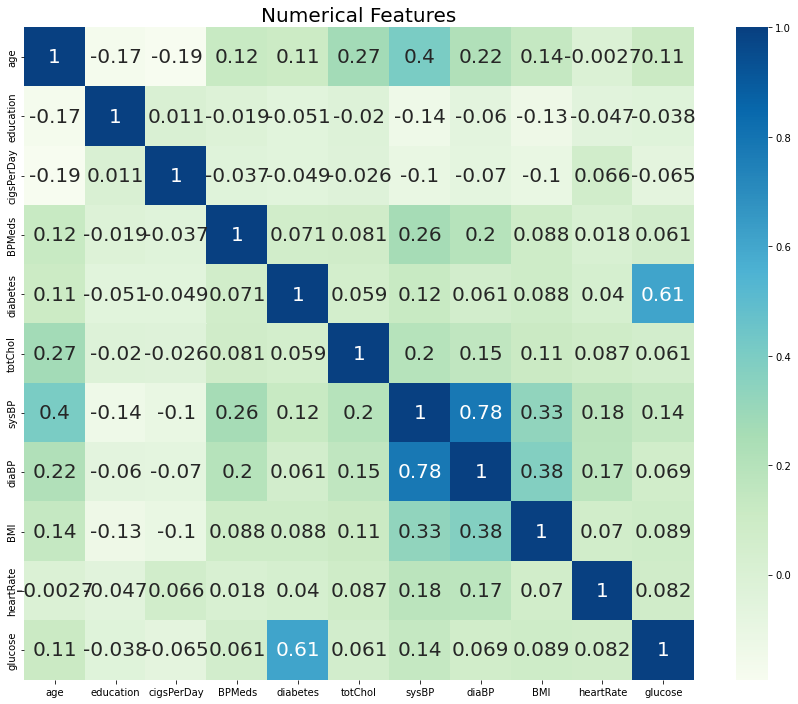

In [ ]:
xy_correlation(numerTrain,"Numerical Features")

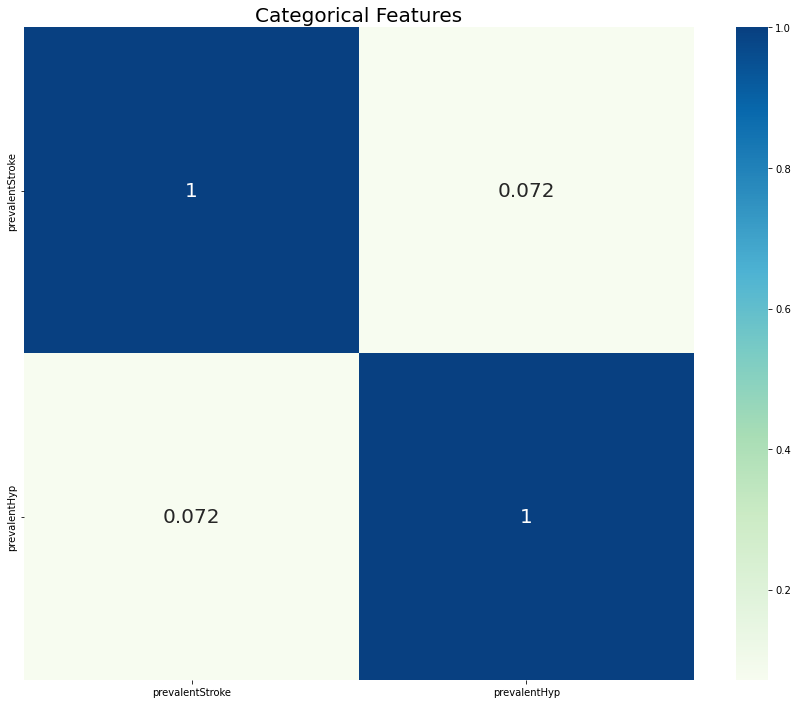

In [ ]:
xy_correlation(categTrain,"Categorical Features")

Nothing too exciting to point out in our categorical correlation apart from missing values (can't figure out why this would be happening), however the numerical shows some strong multicollinearity between diabetes and glucose, as well as hyperbolicBP and systolicBP. 

Assuming dropping one of the two in each case would best limit their affect on our model? 

In [ ]:
FatTrain_y = FatTrain_df["TenYearCHD"]
FatTrain_df = FatTrain_df.drop(['diabetes','diaBP', 'TenYearCHD'], axis=1)
FatTest_df = FatTest_df.drop(['diabetes','diaBP'], axis=1)

In [ ]:
FatTrain_df


,age,education,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,totChol,sysBP,BMI,heartRate,glucose
0,64,2.0,1,1,3.0,0.0,0,0,221.0,148.0,25.481353,90.0,80.0
1,36,4.0,0,0,0.0,0.0,0,1,212.0,168.0,29.770000,72.0,75.0
2,46,1.0,1,1,10.0,0.0,0,0,250.0,116.0,20.350000,88.0,94.0
3,50,1.0,0,1,20.0,0.0,0,1,233.0,158.0,28.260000,68.0,94.0
4,64,1.0,1,1,30.0,0.0,0,0,241.0,136.5,26.420000,70.0,77.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3385,60,1.0,1,0,0.0,0.0,0,0,261.0,123.5,29.280000,70.0,103.0
3386,46,1.0,1,0,0.0,0.0,0,0,199.0,102.0,21.960000,80.0,84.0
3387,44,3.0,0,1,3.0,0.0,0,1,352.0,164.0,28.920000,73.0,72.0
3388,60,1.0,0,0,0.0,0.0,0,1,191.0,167.0,23.010000,80.0,85.0


## Model

In [ ]:
#instantiate the model
FatModel_log = LogisticRegression()

#fit the model using the training data
FatModel_log.fit(FatTrain_df,FatTrain_y)

#use model to make predictions on test data
y_pred = FatModel_log.predict(FatTest_df)

cost_r2 = FatModel_log.score(FatTrain_df, FatTrain_y)
print("R^2: {0}".format(cost_r2))

R^2: 0.8516224188790561


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Getting a nice R^2 here - is this something that can still be relied on with a logistic regression?

In [ ]:
newPD = pd.get_dummies(FatTrain_df, columns=["sex","prevalentStroke", "prevalentHyp", "is_smoking"], drop_first=True)
logit_model = sm.Logit(FatTrain_y, newPD)
result = logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.396634
         Iterations 6
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.065     
Dependent Variable: TenYearCHD       AIC:              2715.1779 
Date:               2022-04-08 22:54 BIC:              2794.8495 
No. Observations:   3390             Log-Likelihood:   -1344.6   
Df Model:           12               LL-Null:          -1437.3   
Df Residuals:       3377             LLR p-value:      3.2433e-33
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     6.0000                                       
-----------------------------------------------------------------
                   Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-----------------------------------------------------------------
age                0.0307   0.0061  5.0488 0.0000  0.0188  0.0426
education         -0.1968   0.0499 -3.9400 0.0001 -0.2946 -0.0989


Uh, now I'm getting really wacky R^2 values?? Ha! I'm clearly underclassed with this logistic regression. Should've picked a different dataset! Don't even want to try and interperet this - have no idea what kind of validity these numbers may or may not have. 

I mean, if we look at low pVal variables one could argue that stroke and hypertension seem to have the largest indicators of having heart disease, with age having a very minimal effect. This would tie in to our original hypothesis, but have no idea on how concrete this is -- best to settle on a funny coincidence that results turned out this way. 

Will have to play around with this kind of modelling some more in the future. From what I've been able to gather online, these can get pretty involved.

## Summary

(speech to text)

OK, this was an interesting dataset to work with. I liked how they gave us separate test and train datasets. It forced me to try and use logistic regression moving forward, but I don’t think I quite pulled it off. Cleaning these took a little more work to make sure we had a nice distribution for the model, though I couldn’t figure out what kind of assumptions to test. When I tried using prior linear assumption tests, the data was all skewed and weird because a lot of the numbers were zeros or ones. I think this was throwing off my residual plots, among other things. I was able to at least do a correlation matrix. In doing so I did find some multicollinearity under the numerical features which were good. Doing the linear regression last time in module 4 I had so much multicollinearity and I didn’t know what to do with it, so it was nice to have that simplified a bit. I just removed anything that was too correlated to try and avoid muddying up our final results and it seems as though that was the right way to go about it in an instance like this. When I actually fitted the model, checked the r squared's, and got the summary, I didn’t really know what I was looking at. My r^2s were all over the place and because I wasn’t able to fully check assumptions, I can’t be too sure what I’m looking at. Despite this, it does seem as though we confirmed that blood pressure and stroke do seem to lead to a higher increase in heart disease. This is most likely due to luck more than anything, but I’ll take what I can get I suppose. It would’ve been interesting to see more data on actual fatness. I guess the BMI variable is what was supposed to indicate that, but it would've been much better to have an actual body fat percentage for each individual. So as far as our differences between the article and this analysis, it primarily revolves around focusing on a prior history of disease rather than body fat percentage (or in their case, BMI metric).  